## <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/'> Source <a/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

lags=60

In [2]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

In [3]:
date = np.array('1992-02', dtype=np.datetime64)
date = date + np.arange(200)
date

array(['1992-02', '1992-03', '1992-04', '1992-05', '1992-06', '1992-07',
       '1992-08', '1992-09', '1992-10', '1992-11', '1992-12', '1993-01',
       '1993-02', '1993-03', '1993-04', '1993-05', '1993-06', '1993-07',
       '1993-08', '1993-09', '1993-10', '1993-11', '1993-12', '1994-01',
       '1994-02', '1994-03', '1994-04', '1994-05', '1994-06', '1994-07',
       '1994-08', '1994-09', '1994-10', '1994-11', '1994-12', '1995-01',
       '1995-02', '1995-03', '1995-04', '1995-05', '1995-06', '1995-07',
       '1995-08', '1995-09', '1995-10', '1995-11', '1995-12', '1996-01',
       '1996-02', '1996-03', '1996-04', '1996-05', '1996-06', '1996-07',
       '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01',
       '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07',
       '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01',
       '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07',
       '1998-08', '1998-09', '1998-10', '1998-11', 

In [4]:
df_y = pd.DataFrame({'Date': date, 'Value':y})
df_y = df_y.set_index('Date')

## Visualizate the data

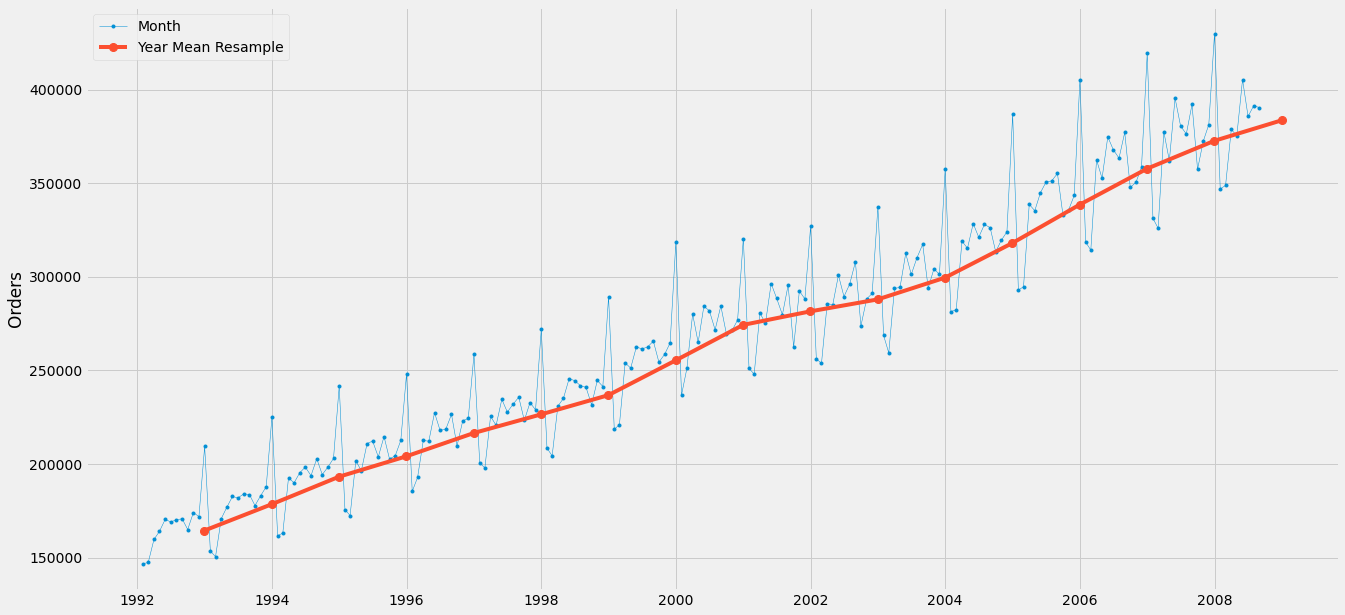

In [5]:

import warnings
import matplotlib.pyplot as plt
y = df_y
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

## Decomposing the Data

In [6]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

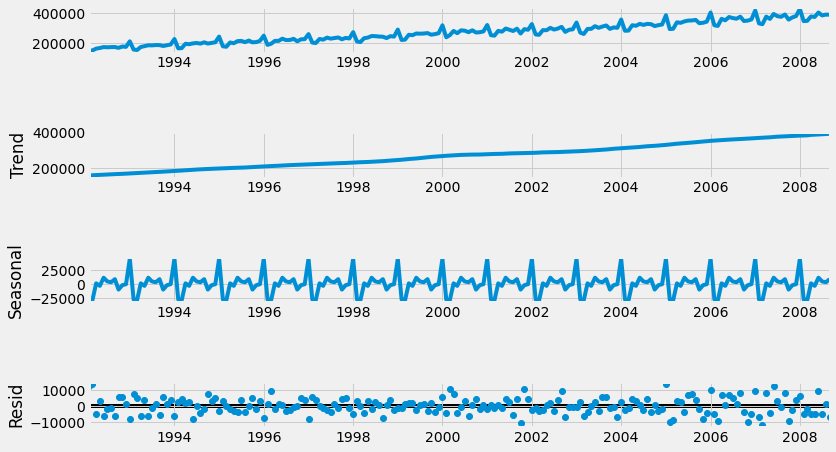

In [7]:
seasonal_decompose(df_y)

## Checking Stationarity

In [8]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

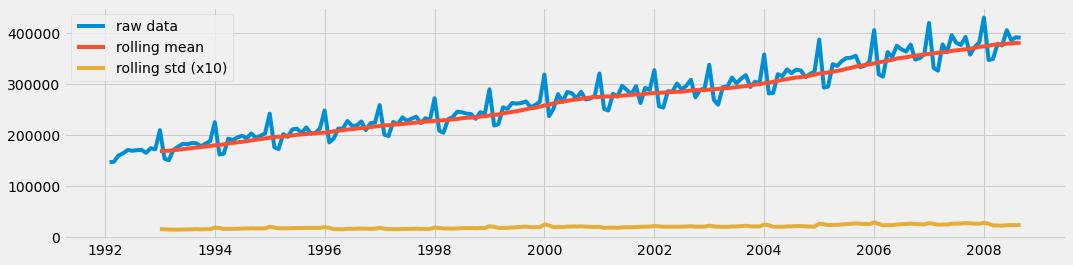

In [9]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y.Value,'raw data')

## Augmented Dickey-Fuller Test

In [10]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [11]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.026
P-value = 0.956
Critical values :
	1%: -3.4662005731940853 - The data is not stationary with 99% confidence
	5%: -2.8772932777920364 - The data is not stationary with 95% confidence
	10%: -2.575167750182615 - The data is not stationary with 90% confidence


## Detrending

 > Is the de-trended data stationary ?
Test statistic = -2.248
P-value = 0.189
Critical values :
	1%: -3.4680615871598537 - The data is not stationary with 99% confidence
	5%: -2.8781061899535128 - The data is not stationary with 95% confidence
	10%: -2.5756015922004134 - The data is not stationary with 90% confidence


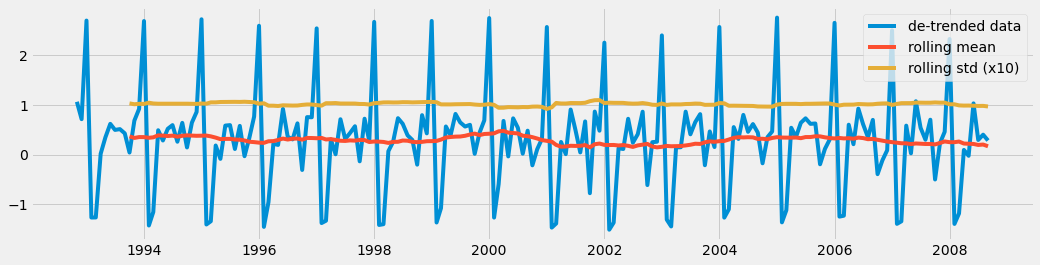

In [12]:
# Detrending
y_detrend =  (y - y.rolling(window=10).mean())/y.rolling(window=10).std()

test_stationarity(y_detrend.Value,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 10 lag differenced data stationary ?
Test statistic = -2.627
P-value = 0.087
Critical values :
	1%: -3.4682803641749267 - The data is not stationary with 99% confidence
	5%: -2.8782017240816327 - The data is not stationary with 95% confidence
	10%: -2.5756525795918366 - The data is  stationary with 90% confidence


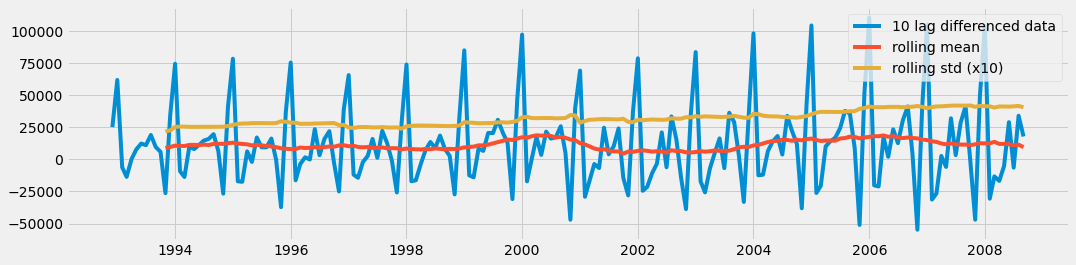

In [14]:
# Differencing
y_10lag =  y - y.shift(10)

test_stationarity(y_10lag.Value,'10 lag differenced data')
ADF_test(y_10lag,'10 lag differenced data')

## Combining Detrending and Differencing


 > Is the 10 lag differenced de-trended data stationary ?
Test statistic = -3.802
P-value = 0.003
Critical values :
	1%: -3.4703698981001665 - The data is  stationary with 99% confidence
	5%: -2.8791138497902193 - The data is  stationary with 95% confidence
	10%: -2.576139407751488 - The data is  stationary with 90% confidence


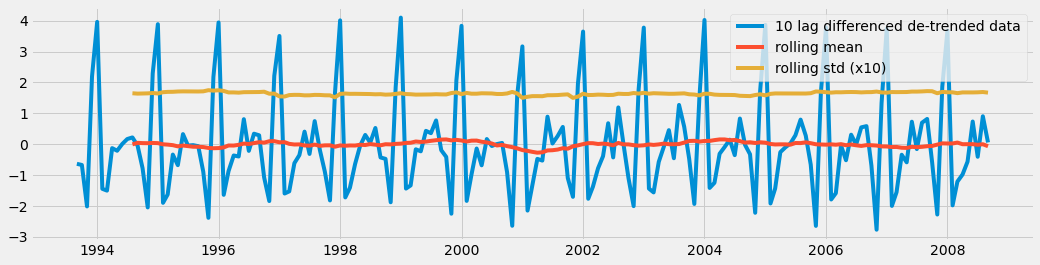

In [15]:
y_10lag_detrend =  y_detrend - y_detrend.shift(10)

test_stationarity(y_10lag_detrend.Value,'10 lag differenced de-trended data')
ADF_test(y_10lag_detrend.Value,'10 lag differenced de-trended data')

## Create Training & Testing Datasets


In [16]:
y_to_train = y[:'2007-05-01'] # dataset to train
y_to_val = y['2007-05-01':] # last X months for test  
predict_date = len(y) - len(y[:'2019-06-02']) # the number of data points for the test set

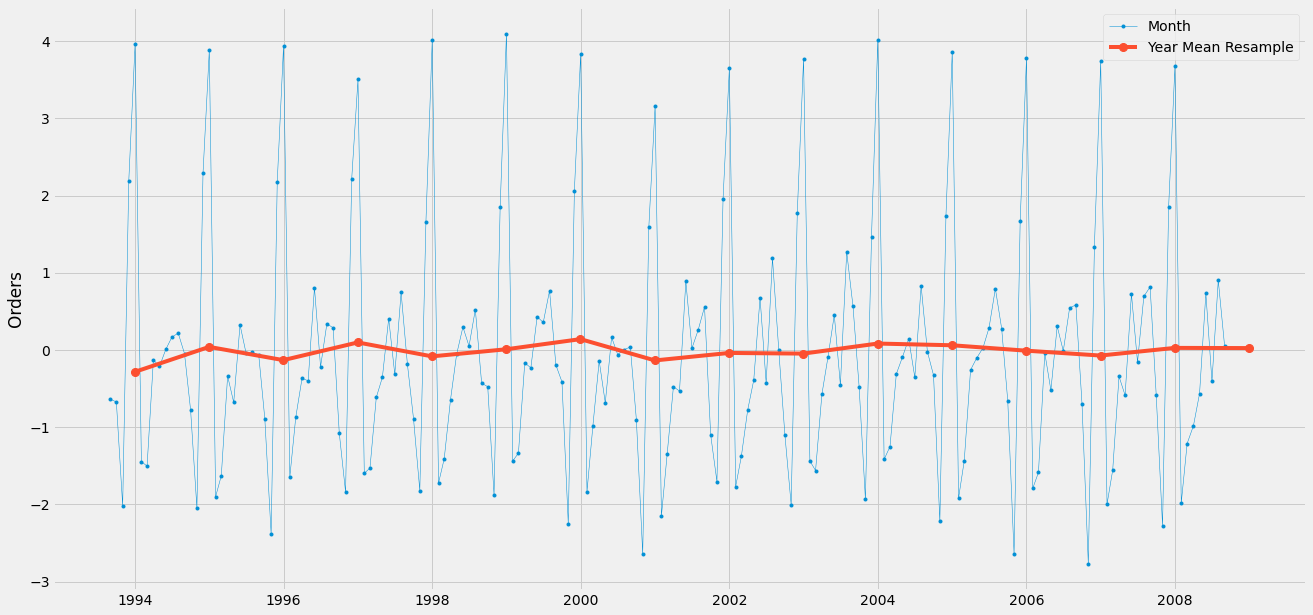

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_10lag_detrend,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y_10lag_detrend.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

# <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/'> Source 2</a>

In [18]:
def calculate_metrics_sample(y):
   
    print('yes')
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return pd.DataFrame(np.array([[metr] for metr in y_dict.values()]).T, 
                        columns=['series', 'observations', 'mode','mean','median',
                                 'variation','skewness','kurtosis','jarque-bera','probability'])#,'params_ar','params_intercept'])

In [19]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(20,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample, marker='o')
    plt.grid(True)
    plt.show();
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

# Metrics

In [20]:
calculate_metrics_sample(y.Value)

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,200,146737.0,268831.08,264861.0,4655234022.07397,0.22007611501127924,-0.8901924464689346,8.309463126688069,0.015690002336133824


In [21]:
y_10lag_detrend

,Value
Date,
1992-02-01,nan
1992-03-01,nan
1992-04-01,nan
1992-05-01,nan
1992-06-01,nan
...,...
2008-05-01,-0.56543642
2008-06-01,0.73297282
2008-07-01,-0.40791391


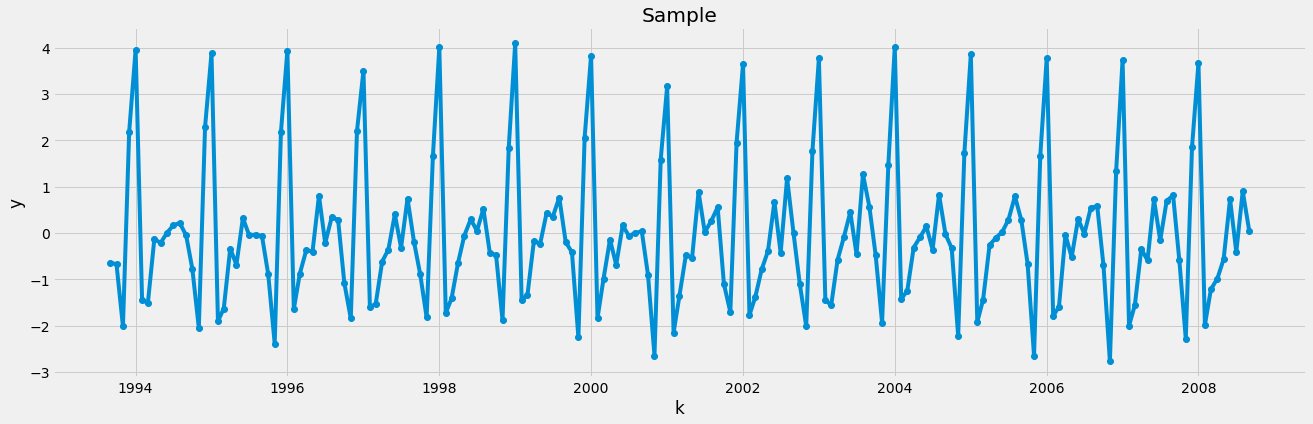

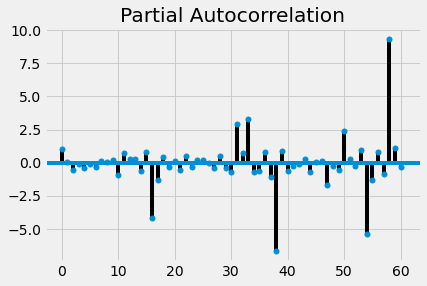

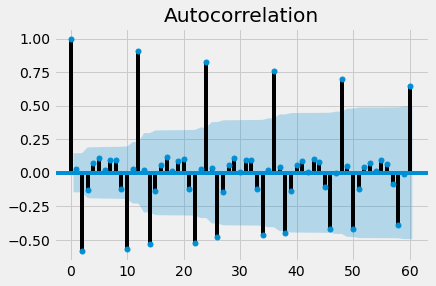

In [22]:
show_plots(y_10lag_detrend.Value.dropna())
# plot_pacf(y_10lag, lags=lags);
# plot_acf(y_10lag, lags=lags);

## Fitting ARIMA Model

In [26]:
def AR(p, df, test=True):
    df_temp = df
    
    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()

    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    return df_train_2,df_test,theta,intercept,RMSE


In [60]:
def claculate_metrics_model(y, y_pred, name, count_parameters):
    return pd.DataFrame({'name':[name],
                              'r2':[r2_score(df_test['Value'], df_test['Predicted_Values'])],
                              'RMSE':[np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))],
#                              'MAPE':[mean_absolute_percentage_error(y, y_pred)],
                              'sum_squared_resid':[np.sum((y - y_pred)**2)],
                              'AIC':[len(y) * np.log(np.sum((y - y_pred)**2) / len(y)) + 2*count_parameters],
                              'durbin_watson': [durbin_watson(y - y_pred)],
                        'theil_index':[np.sqrt((1/len(y_pred))*np.sum((y-y_pred)**2))
                                      / (np.sqrt((1/len(y))*np.sum(y**2)) + np.sqrt((1/len(y_pred))*np.sum(y_pred**2)))],
                        }
        )

## Choosing parameters for AR model

In [61]:
models_metrics_ar = pd.DataFrame(columns=['name', 'r2', 'RMSE','sum_squared_resid','AIC','durbin_watson','theil_index'])

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_10lag_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	26


In [62]:
models_metrics_ar

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),-0.00279034,1.54531177,95.51953903,36.81805479,2.06070856,0.96310880
0,AR(2),0.35719528,1.23723036,61.22955886,21.03002427,2.32279782,0.50758265
0,AR(3),0.36737851,1.22739122,60.25956876,22.39127693,2.27925794,0.50198850
0,AR(4),0.47416691,1.11901266,50.08757329,16.99573940,2.20799169,0.43749303
0,AR(5),0.48445637,1.10801019,49.10746290,18.20526252,2.20492749,0.43789001
0,AR(6),0.56199238,1.02129657,41.72186748,13.68583749,2.11125696,0.39780548
0,AR(7),0.55939453,1.02432078,41.96932254,15.92237927,2.23151742,0.39333949
0,AR(8),0.56653425,1.01598766,41.28923714,17.26889640,2.22900844,0.38920393
0,AR(9),0.60606571,0.96855198,37.52371767,15.44375001,1.89160235,0.36752766
0,AR(10),0.94392727,0.36541545,5.34113804,-60.53762829,1.55261796,0.12196038


In [63]:
best_p = 25
df_train,df_test,theta_ar,intercept_ar,RMSE = AR(best_p,pd.DataFrame(y_10lag_detrend.Value))

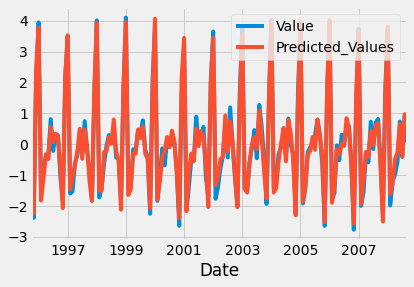

In [64]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

In [65]:
def MA(q, res):
    
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
#     res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

#     print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

In [66]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

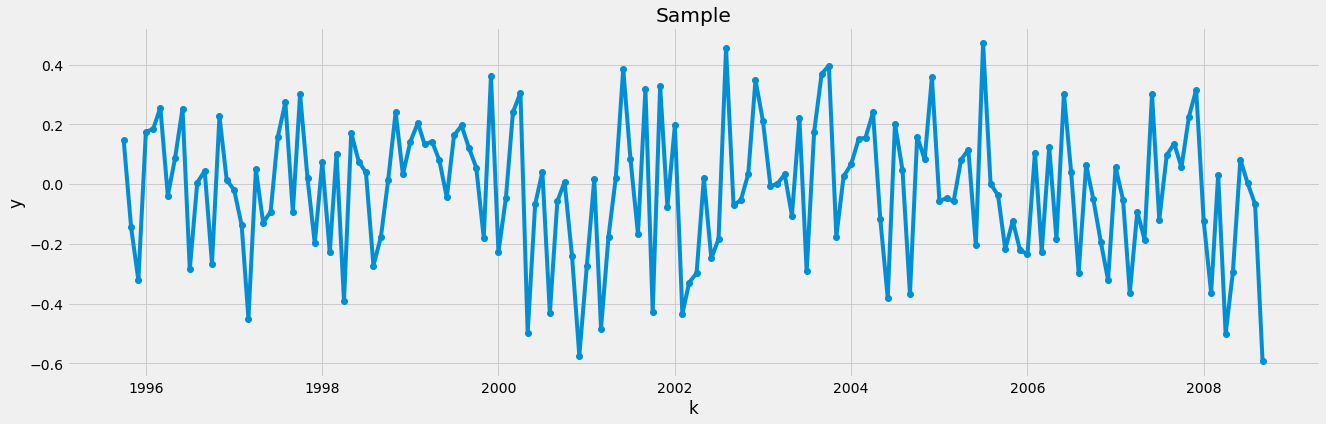

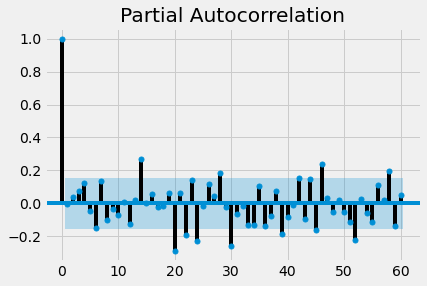

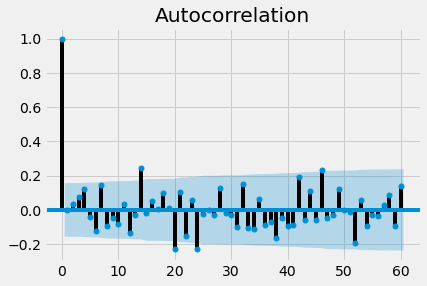

In [67]:
show_plots(res.Residuals.dropna())


## Choosing parameters for MA model

In [68]:
models_metrics_ma = pd.DataFrame(columns=['name', 'r2', 'RMSE','sum_squared_resid','AIC','durbin_watson','theil_index'])


best_RMSE=100000000000
best_q = -1

for i in range(1,50):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    metric = claculate_metrics_model(res_test.Residuals, res_test.Predicted_Values, f'MA({i})', i)
    models_metrics_ma = models_metrics_ma.append(metric)
    
    
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

In [69]:
print(f'best_q:\t {best_q}')

best_q:	 28


In [70]:
models_metrics_ma

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,MA(1),0.97700349,0.23401407,1.73738847,-91.22728940,1.66897311,0.97019166
0,MA(2),0.97700349,0.23401407,1.73445491,-89.28136669,1.67837808,0.95709698
0,MA(3),0.97700349,0.23401407,1.72439438,-87.46751987,1.66988614,0.91694134
0,MA(4),0.97700349,0.23401407,1.69830079,-85.95544599,1.72517641,0.84535218
0,MA(5),0.97700349,0.23401407,1.70231787,-83.87984412,1.75671643,0.84457820
0,MA(6),0.97700349,0.23401407,1.61073031,-83.64954302,1.71635016,0.80442716
0,MA(7),0.97700349,0.23401407,1.55484962,-82.77942629,1.67533700,0.77936614
0,MA(8),0.97700349,0.23401407,1.52275675,-81.44683397,1.68416321,0.76179627
0,MA(9),0.97700349,0.23401407,1.51905281,-79.52476531,1.71360995,0.76062362
0,MA(10),0.97700349,0.23401407,1.50932392,-77.73037078,1.70401373,0.75178994


In [71]:
best_q=20
res_train,res_test,theta_ma,intercept_ma,RMSE = MA(best_q,pd.DataFrame(res.Residuals))
print(f'theta: {theta}')
print(f'intercept: {intercept}')

theta: [[ 0.03586402]
 [ 0.04623576]
 [ 0.05543935]
 [ 0.23708284]
 [-0.1095162 ]
 [-0.02546758]
 [ 0.15052709]
 [-0.14442544]
 [ 0.02365577]
 [-0.08426276]
 [-0.08157886]
 [-0.17035738]
 [ 0.06221191]
 [ 0.26352456]
 [ 0.03174606]
 [ 0.09627893]
 [-0.07630759]
 [-0.08923009]
 [ 0.13274787]
 [-0.32040016]]
intercept: [-0.00086544]


In [72]:
res_c = pd.concat([res_train,res_test])
df_c.Predicted_Values += res_c.Predicted_Values

## Plot before come back to real value

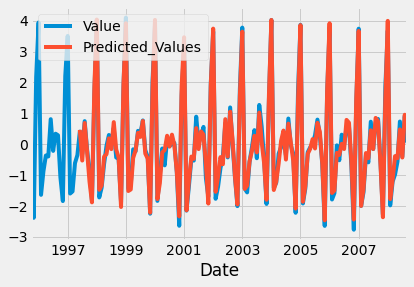

In [73]:
df_c[['Value','Predicted_Values']].plot()

In [74]:
df_c.Predicted_Values += y_detrend.shift(10).Value
df_c.Predicted_Values *= y.rolling(window=10).std().Value
df_c.Predicted_Values += y.rolling(window=10).mean().Value


df_c.Value += y_detrend.shift(10).Value
df_c.Value *= y.rolling(window=10).std().Value
df_c.Value += y.rolling(window=10).mean().Value


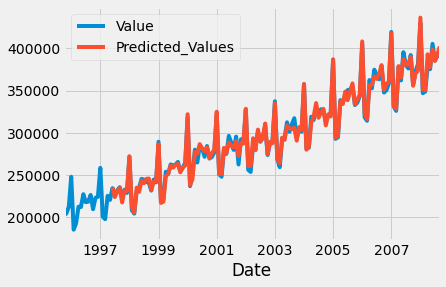

In [75]:
df_c.iloc[:,:][['Value','Predicted_Values']].plot()

In [46]:
def show_prediction(y, y_pred, name='', pred_title='pred'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y, label='y', marker='o')
    plt.plot(y_pred, label=pred_title, marker='o')
    plt.legend()
    plt.show()

## Plot after come back

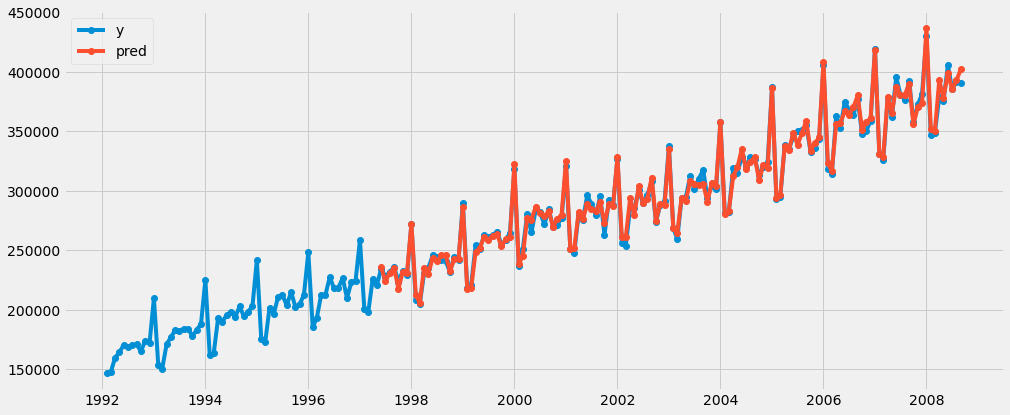

In [47]:
show_prediction(y, df_c.Predicted_Values)

## metrix for ARIMA model

In [80]:
predictions = df_c.Predicted_Values.dropna()
values = y.Value[df_c.Predicted_Values.dropna().index]
name = f'ARMA{best_p,best_q}'
parametrs = best_p+best_q
claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARMA(25, 20)",0.97700349,0.23401407,2569333044.14190531,2368.57899287,1.89482989,0.00704468


# Fiting AR model on detrended values

usnig only detrending values

In [83]:
calculate_metrics_sample(y_detrend.Value.dropna())

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,191,-1.5139975973039137,0.29430675771472503,0.3547550682481003,0.9700530694941747,0.36764637130392375,0.8640800289136732,9.461555070875926,0.008819610813081469


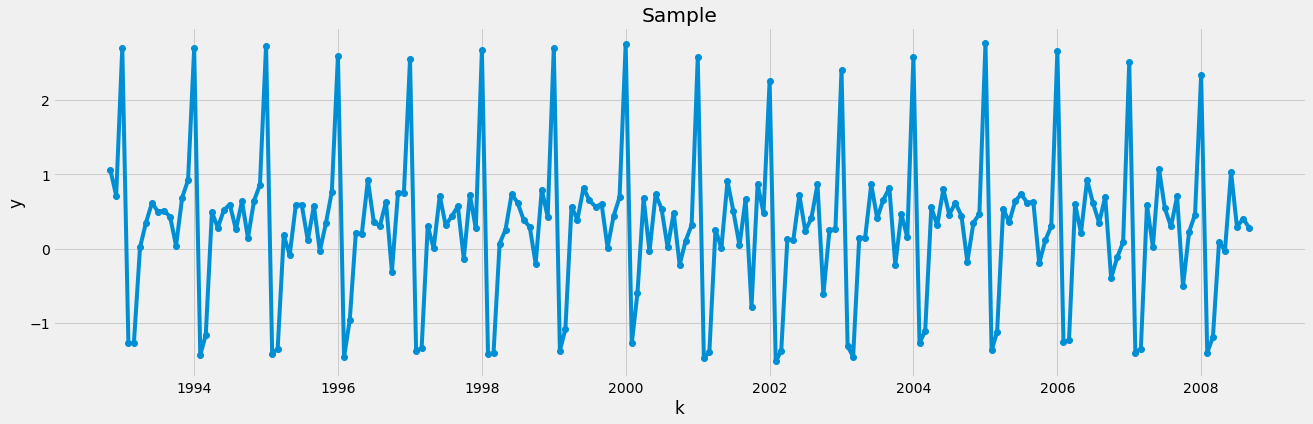

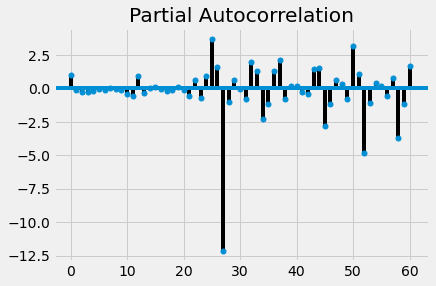

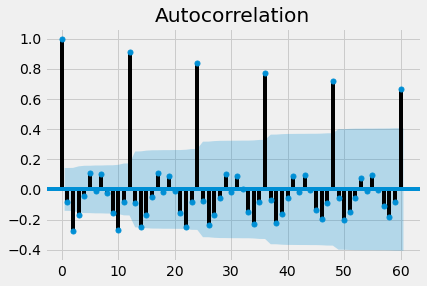

In [84]:
show_plots(y_detrend.Value.dropna())

## Choosing AR model

In [85]:
models_metrics_ar = pd.DataFrame(columns=['name', 'r2', 'RMSE','sum_squared_resid','AIC','durbin_watson','theil_index'])

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	36


In [86]:
models_metrics_ar

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),0.01118040,0.92418014,34.16435754,-4.30786123,2.11813363,0.72532488
0,AR(2),0.11454712,0.87454232,30.59297052,-6.72436773,2.21391403,0.64056798
0,AR(3),0.16775086,0.84786123,28.75474657,-7.20306409,2.22198075,0.59497841
0,AR(4),0.21443684,0.82373715,27.14171595,-7.51230303,2.15795602,0.55847415
0,AR(5),0.21796702,0.82188421,27.01974586,-5.69246109,2.14980785,0.55796864
0,AR(6),0.24289557,0.80867868,26.15844846,-4.98828955,2.10456502,0.54106873
0,AR(7),0.24526770,0.80741082,26.07648955,-3.11381317,2.12035113,0.53855340
0,AR(8),0.24287517,0.80868958,26.15915322,-0.98721189,2.11768212,0.53591847
0,AR(9),0.22443020,0.81848089,26.79643880,1.97558176,2.24593683,0.53316252
0,AR(10),0.39373585,0.72365079,20.94681885,-5.87570656,2.50568277,0.44093224


In [87]:
best_p = 36
df_train,df_test,theta_ar,intercept_ar,RMSE = AR(best_p,pd.DataFrame(y_detrend.Value))

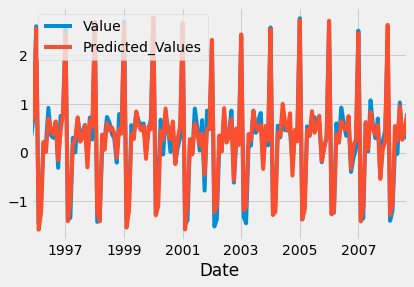

In [90]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

## detrended come back to real value

In [91]:
df_c.Value *= y.rolling(window=10).std().Value
df_c.Value += y.rolling(window=10).mean().Value

df_c.Predicted_Values *= y.rolling(window=10).std().Value
df_c.Predicted_Values += y.rolling(window=10).mean().Value

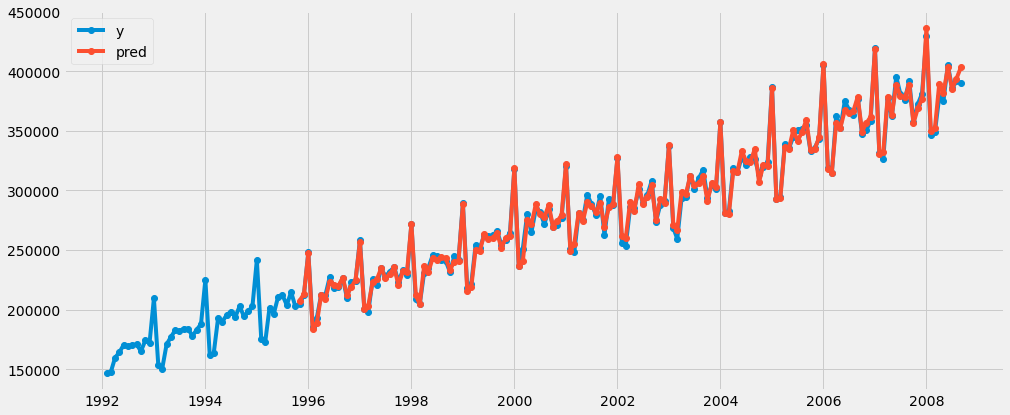

In [92]:
show_prediction(y, df_c.Predicted_Values)

In [93]:
predictions = df_c.Predicted_Values.dropna()
values = y.Value[df_c.Predicted_Values.dropna().index]
name = f'AR{best_p}'
parametrs = best_p
claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR36,0.96089665,0.18378290,2200825405.82912779,2624.64434515,1.77591958,0.00630506


# Linear model 

In [223]:
from sklearn.preprocessing import PolynomialFeatures

def trend_equal(y, trend=1):   
    
    
    df_temp = y
    
    date_start = np.array(str(df_temp.index[0])[:7], dtype=np.datetime64)
    date_start = date_start + np.arange(len(y))
    y_new = df_temp.values

    X = np.array([x for x in range(1, len(df_temp))])
    X = np.reshape(X, (len(X), 1))
    
    train_size = (int)(0.8 * df_temp.shape[0])
#     print(f'train_size:\t')
    df_train = pd.DataFrame(y[:train_size])
    df_test = pd.DataFrame(y[train_size:])
    
    x_train = pd.DataFrame(X[:train_size])
    y_train = pd.DataFrame(y_new[:train_size])

    x_test = pd.DataFrame(X[train_size - 1:])
    y_test = pd.DataFrame(y_new[train_size:])
#     
#     print(f'x_test_shape:\t{x_test.shape}')

    
    if trend != 1:
        pf = PolynomialFeatures(degree=trend)
        x_train = pf.fit_transform(x_train)
        x_test = pf.fit_transform(x_test)

#     print(f'x_test_shape_poly:\t{x_test.shape}')
#     print(f'x_test_shape:\t{y_test.shape}')
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    
    pred_train = np.reshape(pred_train, (len(pred_train), ))
    pred_test = np.reshape(pred_test, (len(pred_test, )))
    
#     print(f'test:\t{len(pred_test)}\ntrain:\t{len(pred_train)}')
    
#     pred_train =  list(pred_train) + list( [0]*(len(y) - len(pred_train)))
#     pred_test = list( [np.nan]*(len(y) - len(pred_test))) + list(pred_test)
    
#     print(f'data_test:\t{len(date_start[:train_size])}\ndata_train:\t{len(date_start[train_size:])}')

    train_df = pd.DataFrame({'Date': date_start[:train_size], 'Value': pred_train}).set_index('Date')
    test_df = pd.DataFrame({'Date': date_start[train_size :], 'Value': pred_test}).set_index('Date')
    
    df_train['Predicted_Values'] = train_df.Value
    df_test['Predicted_Values'] = test_df.Value  
    
#     print(df_test)
    
    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))
    
    return df_train, df_test, model.coef_, model.intercept_, RMSE

In [231]:
models_metrics_trend = pd.DataFrame(columns=['name', 'r2', 'RMSE','sum_squared_resid','AIC','durbin_watson','theil_index'])

best_RMSE = 1e15
best_t = -1

for i in range(1, 6):
#     print(i)
    df_train, df_test, theta, intercept, RMSE = trend_equal(pd.DataFrame(y.Value), i)
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'trend({i})', i)
    models_metrics_trend = models_metrics_trend.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_t = i
        
print(f'best_p:\t{best_t}')

best_p:	4


In [232]:
models_metrics_trend

,name,r2,RMSE,sum_squared_resid,AIC,durbin_watson,theil_index
0,trend(1),-0.17687544,28304.85192563,32046585701.27745438,822.06308121,1.40557758,0.03955879
0,trend(2),-0.25765830,29260.17830506,34246321377.74558258,826.71862147,1.31530643,0.04097995
0,trend(3),-0.11234638,27517.92363755,30289444852.89115906,823.80742720,1.48709264,0.03838915
0,trend(4),-0.09899950,27352.33361861,29926006175.35693741,825.32457028,1.50514916,0.03814280
0,trend(5),-11.76135212,93206.02429641,347494518605.69409180,925.40541096,0.13402737,0.11590399


In [243]:
best_t = 4
df_train_trend, df_test_trend, theta_trend, intercept_trend, RMSE = trend_equal(pd.DataFrame(y.Value), best_t)

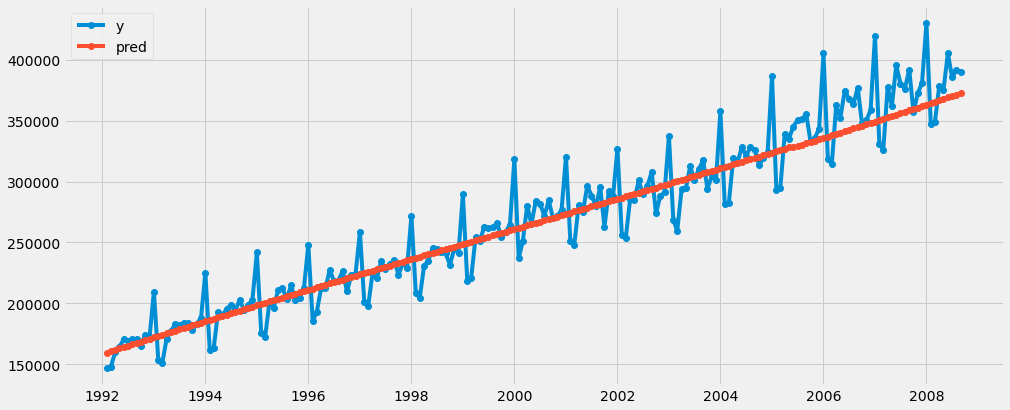

In [244]:
df_c = pd.concat([df_train_trend,df_test_trend])
show_prediction(y, df_c.Predicted_Values)